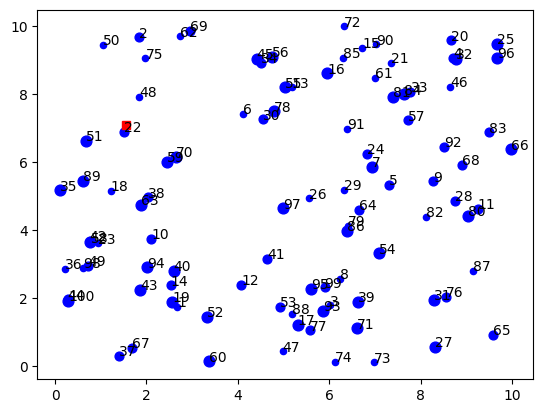

26


In [40]:
import random
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt

N=100 #performance of algorithm
V=set(range(N+1))
location = [(np.random.uniform(0,10),np.random.uniform(0,10))]
plt.plot(location[-1][0],location[-1][1],'rs')

d=[0]
for i in V - {0}:
    location.append((np.random.uniform(0,10),np.random.uniform(0,10)))
    d.append(random.randint(1,3))
    plt.scatter(location[-1][0],location[-1][1],d[-1]*20,'b')
    plt.text(location[-1][0],location[-1][1],i)
    

plt.show()

def distance (a,b):
    return math.sqrt((a[0]-b[0])*(a[0]-b[0])+(a[0]-b[0])*(a[0]-b[0]))

c=[[0 if i==j
    else distance(location[i],location[j])
    for j in V] for i in V]

Capacity = 8 #capacity of truck
M = math.ceil(sum(d)/Capacity)

print (M) #illustration of the problem

In [63]:
customer_permutation = np.random.permutation(N)+1
seed_customer = set(customer_permutation[0:M])

def VRP_from_seed(seed_customer,N,V,d,c,Capacity,M):
    
    other_customer = V - {0} - seed_customer
    
    allocating_cost={}
    for i in other_customer:
        for m in seed_customer:
            allocating_cost[i,m] = min(c[0][i]+c[i][m]+c[m][0],c[0][m]+c[m][i]+c[i][0])-(c[0][m]+c[m][0])
            allocating_cost[i,m] = round(allocating_cost[i,m]*1000)
            
    G = nx.DiGraph()
    for m in seed_customer:
        G.add_node(m,demand = -(Capacity-d[m]))
    for i in other_customer:
        G.add_node(i,demand = d[i])
    for i in other_customer:
        for m in seed_customer:
            G.add_edge(m,i,weight = allocating_cost[i,m])
    G.add_node(0,demand = Capacity*M-sum(d))
    for m in seed_customer:
        G.add_edge(m,0,weight=0)
    flowCost,flowDict = nx.network_simplex(G)
    
    group=[]
    for m in seed_customer:
        subgroup = [0,m]
        for i in other_customer:
            if flowDict[m][i]>0.1:
                subgroup.append(i)
            group.append(subgroup)
        c_group=[]
        location_group=[]
        for subgroup in group:
            c_group.append([[c[i][j] for j in subgroup] for i in subgroup])
            location_group.append([location[i] for i in subgroup])
    return group
            
            
class GA:
    def __init__(self, gene_size, pop_size, gene_range = 1, double_child_size = 10, selection_power = 0.5, crossover_rate = 0.4, mutation_rate = 0.2):
        self.gene_size = gene_size
        self.gene_range = gene_range
        self.pop_size = pop_size
        self.double_child_size = double_child_size
        self.sel = selection_power
        self.crs = crossover_rate
        self.mut = mutation_rate
        self.cost_record = []
        
        self.gene_pool = []
        for i in range(self.pop_size):
            gene = [random.randint(0,self.gene_range) for j in range(self.gene_size)]
            gene,_ = self.gene_screening(gene)
            self.gene_pool.append((gene,self.evaluate(gene)))
            
        self.order()
        
    def evaluate(self,gene):
        seed_customer = set([i + 1 for i in gene])
        if len(seed_customer)<M:
            return math.inf
        else:
            groups = VRP_from_seed(seed_customer, N, V, d, c, Capacity,     M)
            total_cost = sum([sum(group) for group in groups])
            return total_cost
            #return VRP_from_seed(seed_customer,N,V,d,c,Capacity,M)
        
    def order(self):
        self.gene_pool.sort(key=lambda item: item[1])
        
    def is_uniqueness(self,gene):
        for existing_gene in self.gene_pool:
            if existing_gene[0] == gene:
                return False
            return True
        
    def gene_screening(self,gene):
        remove_overlaps = set(gene)
        if len(remove_overlaps)==len(gene):
            gene.sort()
            return (gene,True)
        else:
            leftover = len(gene)-len(remove_overlaps)
            gene = list(remove_overlaps)
            for i in range(leftover):
                gene.append(random.randint(0,self.gene_range))
            gene_pass = False
            while not gene_pass:
                (gene,gene_pass)=self.gene_screening(gene)
            gene.sort()
            return(gene,True)
        
    def generate(self):
        for m in range(self.double_child_size):
            id1=int(min(round(abs(np.random.normal())/self.sel),self.pop_size-1))
            id2=int(min(round(abs(np.random.normal())/self.sel),self.pop_size-1))
        while id2==id1:
            id2=int(min(round(abs(np.random.normal())/self.sel),self.pop_size-1))
        #print(id1,id2)
        gene1=self.gene_pool[id1][0]
        gene2=self.gene_pool[id2][0]
        child_gene1=[]
        child_gene2=[]
        for i in range(self.gene_size):
            if np.random.uniform(0,1)<self.crs:
                child_gene1.append(gene2[i])
                child_gene2.append(gene1[i])
            else:
                child_gene1.append(gene1[i])
                child_gene2.append(gene2[i])
            if np.random.uniform(0,1)<self.mut:
                child_gene1[i]=random.randint(0,self.gene_range)
            if np.random.uniform(0,1)<self.mut:
                child_gene2[i]=random.randint(0,self.gene_range)
                
            child_gene1,_=self.gene_screening(child_gene1)
            child_gene2,_=self.gene_screening(child_gene2)
            
            if self.is_uniqueness(child_gene1):
                self.gene_pool.append((child_gene1,self.evaluate(child_gene1)))
            
            if self.is_uniqueness(child_gene2):
                self.gene_pool.append((child_gene2,self.evaluate(child_gene2)))
                
            self.order()
            del self.gene_pool[self.pop_size:] 
            
    def run(self, max_generation):
        for i in range(max_generation):
            self.generate()
            #print([gene_val[1] for gene_val in self.gene_pool])
            self.cost_record.append(self.gene_pool[0][1])
        return self.gene_pool[0][0]

In [64]:
ga = GA(M,20,N-1,double_child_size=20,mutation_rate=0.5)

In [67]:
ga.run(100)

[2,
 13,
 26,
 27,
 28,
 30,
 32,
 33,
 37,
 45,
 47,
 48,
 50,
 63,
 65,
 68,
 70,
 72,
 74,
 75,
 79,
 89,
 94,
 95,
 96,
 99]

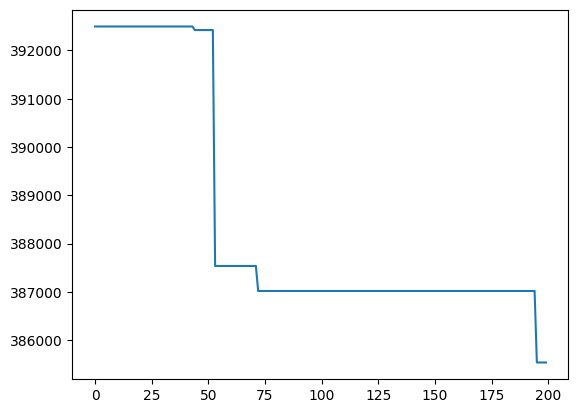

In [68]:
plt.plot(ga.cost_record)
plt.show()